<a href="https://colab.research.google.com/github/zpsy-hub/Data-Mining-Principles/blob/main/Data_Mining_Principles_Clustering_w_out_Avg_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

!pip install kneed

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# **Load and Explore Data**

In [ ]:
# Load datasets
df_transaction = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Transaction_Data_cleaned.csv')
df_customer_feedback = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Customer_Feedback_Data_cleaned.csv')
df_product_offering = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Product_Offering_Data_cleaned.csv')

# Check data shapes
print("Transaction data shape:", df_transaction.shape)
print("Feedback data shape:", df_customer_feedback.shape)
print("Product data shape:", df_product_offering.shape)

Transaction data shape: (5000, 9)
Feedback data shape: (4959, 4)
Product data shape: (10, 7)


# **Feature Engineering**

1. **Transaction Volume Features**
   - **Total_Transaction_Amount**: Sum of all customer spending
   - **Transaction_Count**: Number of transactions per customer
   - **Avg_Transaction_Amount**: Average spending per transaction

2. **Transaction Composition Features**
   - **Transaction Type %**: Proportion of each transaction type per customer
   - **Amount Categories %**: Distribution across amount categories (Low to Very High)

3. **Engagement Features**
   - **Days_Since_Last_Transaction**: Recency indicator
   - **Engagement_Score**: Combined transaction and feedback engagement
   - **Customer_Value**: Weighted metric of transaction value and frequency

4. **RFM Features**
   - **R/F/M_Quartile**: Customer quartile scores (1-4) for recency, frequency and monetary value
   - **RFM_Score**: Combined RFM metric

5. **Satisfaction Metric**
   - **Avg_Recommendation**: Average likelihood to recommend score

These features were created to capture spending patterns, engagement levels, customer value, and satisfaction metrics to identify distinct customer segments for targeted financial product recommendations.

In [ ]:
# Get unique customers
unique_customers = df_transaction['Customer_ID'].unique()
customer_features = pd.DataFrame({'Customer_ID': unique_customers})

# Transaction amount metrics
transaction_amount = df_transaction.groupby('Customer_ID')['Transaction_Amount'].agg(
    ['sum', 'count', 'mean', 'min', 'max']).reset_index()
transaction_amount.columns = ['Customer_ID', 'Total_Transaction_Amount',
                             'Transaction_Count', 'Avg_Transaction_Amount',
                             'Min_Transaction_Amount', 'Max_Transaction_Amount']

# Transaction types
transaction_types = pd.crosstab(
    df_transaction['Customer_ID'],
    df_transaction['Transaction_Type'],
    normalize='index'
).reset_index()

# Transaction amount categories
transaction_categories = pd.crosstab(
    df_transaction['Customer_ID'],
    df_transaction['Transaction_Amount_Category'],
    normalize='index'
).reset_index()

# Feedback metrics (REMOVE Avg_Satisfaction)
feedback_metrics = df_customer_feedback.groupby('Customer_ID').agg(
    Feedback_Count=('Satisfaction_Score', 'count'),
    Avg_Recommendation=('Likelihood_to_Recommend', 'mean')
).reset_index()  # Removed 'Avg_Satisfaction'

# Merge all features
customer_features = customer_features.merge(transaction_amount, on='Customer_ID', how='left')
customer_features = customer_features.merge(transaction_types, on='Customer_ID', how='left')
customer_features = customer_features.merge(transaction_categories, on='Customer_ID', how='left')
customer_features = customer_features.merge(feedback_metrics, on='Customer_ID', how='left')

# Add recency feature
last_transaction_date = df_transaction.groupby('Customer_ID')['Transaction_Date'].max().reset_index()
last_transaction_date.columns = ['Customer_ID', 'Last_Transaction_Date']
max_date = pd.Timestamp('2023-07-31')

# Ensure Last_Transaction_Date is datetime type
last_transaction_date['Last_Transaction_Date'] = pd.to_datetime(last_transaction_date['Last_Transaction_Date'])
last_transaction_date['Days_Since_Last_Transaction'] = (
    max_date - last_transaction_date['Last_Transaction_Date']
).dt.days
customer_features = customer_features.merge(
    last_transaction_date[['Customer_ID', 'Days_Since_Last_Transaction']],
    on='Customer_ID', how='left'
)

# Is repeat customer?
customer_features['Is_Repeat_Customer'] = customer_features['Transaction_Count'] > 1

# Fill NaNs
customer_features = customer_features.fillna(0)

# Create engagement score
customer_features['Engagement_Score'] = (
    (customer_features['Transaction_Count'] / customer_features['Transaction_Count'].max()) * 0.7 +
    (customer_features['Feedback_Count'] / customer_features['Feedback_Count'].max()) * 0.3
) * 10

# Create customer value score
customer_features['Customer_Value'] = (
    (customer_features['Total_Transaction_Amount'] / customer_features['Total_Transaction_Amount'].max()) * 0.8 +
    (customer_features['Transaction_Count'] / customer_features['Transaction_Count'].max()) * 0.2
) * 10

# Print with new features (without Avg_Satisfaction)
customer_features.head(5)


,Customer_ID,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Min_Transaction_Amount,Max_Transaction_Amount,Bill Payment,Investment,Loan Payment,Purchase,High,Low,Medium,Very High,Feedback_Count,Avg_Recommendation,Days_Since_Last_Transaction,Is_Repeat_Customer,Engagement_Score,Customer_Value
0,393,22365.000000,7,3195.000000,1535.0,4968.000000,0.428571,0.428571,0.000000,0.142857,0.428571,0.000000,0.285714,0.285714,1,3.0,7,True,4.000000,1.442427
1,826,8182.422663,3,2727.474221,323.0,4123.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000,0.666667,6,5.5,15,True,3.000000,0.595261
2,916,18406.000000,9,2045.111111,10.0,4616.000000,0.333333,0.111111,0.333333,0.222222,0.111111,0.444444,0.222222,0.222222,7,5.0,34,True,6.461538,1.685419
3,109,7492.000000,5,1498.400000,72.0,4549.000000,0.200000,0.400000,0.200000,0.200000,0.200000,0.600000,0.000000,0.200000,3,7.0,77,True,3.384615,0.891670
4,889,6348.834015,3,2116.278005,1531.0,3024.834015,0.000000,1.000000,0.000000,0.000000,0.333333,0.000000,0.666667,0.000000,5,5.6,108,True,2.769231,0.565295


# **RFM**

RFM (Recency, Frequency, Monetary) analysis is an industry-standard customer segmentation technique that identifies customer value based on three key metrics:

- **Recency**: How recently a customer made a transaction
- **Frequency**: How often a customer makes transactions
- **Monetary**: How much a customer spends

For FinMark, RFM analysis is crucial because it:

1. Identifies high-value customers (high RFM score) who may benefit from premium offerings
2. Highlights at-risk customers (high M, but low R) who need retention efforts
3. Reveals potential for cross-selling to consistent customers (high F)
4. Enables targeted marketing based on behavioral patterns

For example, a customer with an RFM score of 12 (R=4, F=4, M=4) represents the most valuable segment who recently transacted, does so frequently, and spends significantly—making them ideal candidates for premium financial products.

In [ ]:
# Calculate RFM (Recency, Frequency, Monetary) metrics
rfm = customer_features[['Customer_ID', 'Days_Since_Last_Transaction',
                        'Transaction_Count', 'Total_Transaction_Amount']].copy()
rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']

# Convert recency to a score where lower is better
rfm['Recency'] = rfm['Recency'].max() - rfm['Recency']

# Create quartiles
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to integers
rfm['R_Quartile'] = rfm['R_Quartile'].astype(int)
rfm['F_Quartile'] = rfm['F_Quartile'].astype(int)
rfm['M_Quartile'] = rfm['M_Quartile'].astype(int)

# RFM Score
rfm['RFM_Score'] = rfm['R_Quartile'] + rfm['F_Quartile'] + rfm['M_Quartile']

# Merge RFM metrics back to customer features
customer_features = customer_features.merge(
    rfm[['Customer_ID', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'RFM_Score']],
    on='Customer_ID', how='left'
)

# Print with new features
customer_features.head(5)

,Customer_ID,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Min_Transaction_Amount,Max_Transaction_Amount,Bill Payment,Investment,Loan Payment,Purchase,...,Feedback_Count,Avg_Recommendation,Days_Since_Last_Transaction,Is_Repeat_Customer,Engagement_Score,Customer_Value,R_Quartile,F_Quartile,M_Quartile,RFM_Score
0,393,22365.000000,7,3195.000000,1535.0,4968.000000,0.428571,0.428571,0.000000,0.142857,...,1,3.0,7,True,4.000000,1.442427,4,4,4,12
1,826,8182.422663,3,2727.474221,323.0,4123.000000,0.333333,0.000000,0.333333,0.333333,...,6,5.5,15,True,3.000000,0.595261,3,1,2,6
2,916,18406.000000,9,2045.111111,10.0,4616.000000,0.333333,0.111111,0.333333,0.222222,...,7,5.0,34,True,6.461538,1.685419,2,4,4,10
3,109,7492.000000,5,1498.400000,72.0,4549.000000,0.200000,0.400000,0.200000,0.200000,...,3,7.0,77,True,3.384615,0.891670,1,2,1,4
4,889,6348.834015,3,2116.278005,1531.0,3024.834015,0.000000,1.000000,0.000000,0.000000,...,5,5.6,108,True,2.769231,0.565295,1,1,1,3


# **Prepare Data and Scaling for Clustering**

This code selects relevant customer features for clustering (transaction metrics, engagement indicators, and RFM values) and standardizes them with StandardScaler to ensure each feature contributes equally during K-means clustering. Standardization is critical because K-means uses distance calculations that would otherwise be dominated by features with larger numerical ranges.

In [ ]:
# Select features for clustering
clustering_features = [
    'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
    'Bill Payment', 'Investment', 'Loan Payment', 'Purchase',  # Transaction type percentages
    'Low', 'Medium', 'High', 'Very High',  # Transaction amount categories
    'Avg_Satisfaction', #'Avg_Recommendation',removed due to ANOVA
    'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value',
    'R_Quartile', 'F_Quartile', 'M_Quartile'
]

# Make sure all features exist in the dataframe
clustering_features = [f for f in clustering_features if f in customer_features.columns]
print(f"Using {len(clustering_features)} features for clustering: {clustering_features}")

# Create a subset for clustering
cluster_data = customer_features[clustering_features].copy()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

Using 17 features for clustering: ['Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount', 'Bill Payment', 'Investment', 'Loan Payment', 'Purchase', 'Low', 'Medium', 'High', 'Very High', 'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value', 'R_Quartile', 'F_Quartile', 'M_Quartile']


# **Finding the Optimal Number of Customer Segments Using the Elbow Method**
This code finds the optimal number of clusters for K-means by plotting the "inertia" (within-cluster variance) for different cluster counts. The "elbow point" where the line bends (marked with a red line at k=3) indicates the best balance between too few and too many clusters for the customer segmentation.

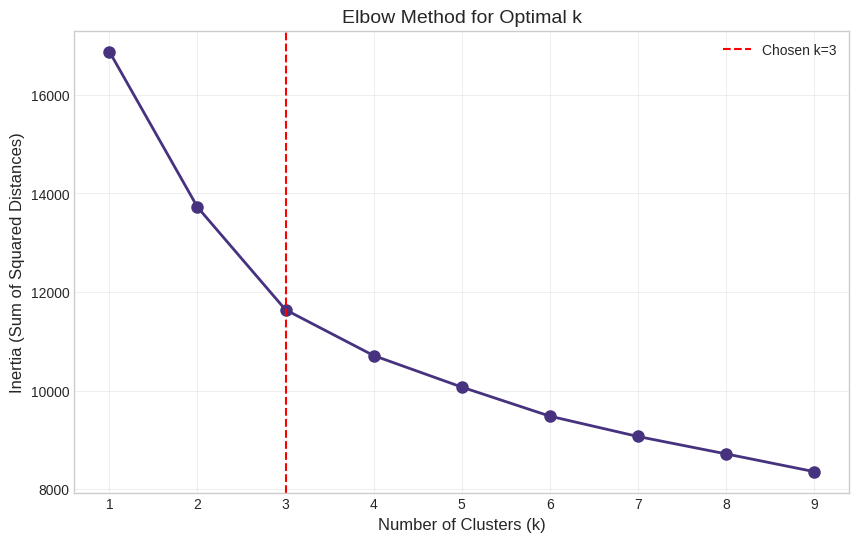

In [ ]:
# Elbow Method to find optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate inertia (sum of squared distances to closest centroid) for different k values
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)

# Add a vertical line at k=3 to indicate chosen value
plt.axvline(x=3, linestyle='--', color='red', label='Chosen k=3')
plt.legend()
plt.show()



# **Evaluating Cluster Quality with Silhouette Analysis**

This code calculates and plots silhouette scores for different numbers of clusters (k) to evaluate clustering quality. The silhouette score measures how similar objects are to their own cluster compared to other clusters, with higher scores indicating better-defined clusters. The plot shows that k=3 (marked by the red line) provides the optimal balance of cluster separation and cohesion for the customer segmentation model.

For k=2: Silhouette Score = 0.184
For k=3: Silhouette Score = 0.188
For k=4: Silhouette Score = 0.137
For k=5: Silhouette Score = 0.121
For k=6: Silhouette Score = 0.123
For k=7: Silhouette Score = 0.118
For k=8: Silhouette Score = 0.122
For k=9: Silhouette Score = 0.120


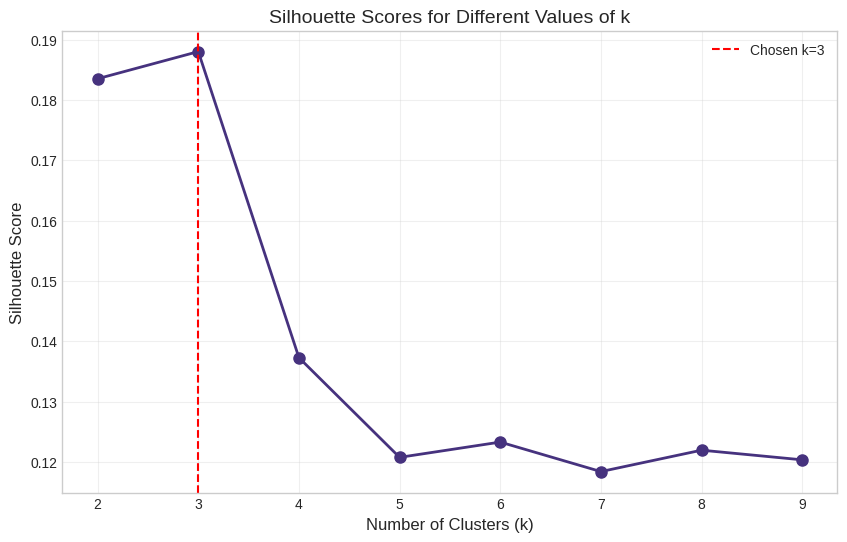

In [ ]:
# Silhouette Scores for different k values
silhouette_scores = []

for k in range(2, 10):  # Silhouette score not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}: Silhouette Score = {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Different Values of k', fontsize=14)
plt.xticks(range(2, 10))

# Add a vertical line at k=3 to indicate chosen value
plt.axvline(x=3, linestyle='--', color='red', label='Chosen k=3')
plt.legend()
plt.show()


The silhouette score measures how well customers fit within their assigned clusters. A score ranges from -1 to 1, where:

- Higher scores (closer to 1): Customers are very similar to others in their group and different from those in other groups.
- Scores near 0: Customers are on the border between clusters.
- Negative scores: Customers might be in the wrong cluster.

Looking at the results:
- The best score was 0.188 for 3 clusters, which is positive but not very high
- This means there are some natural groupings, but with overlap between customer segments
- When trying more clusters (4+), the scores drop significantly (below 0.14), showing that forcing more divisions makes the groupings less meaningful

The results suggest that dividing FinMark's customers into 3 segments provides the most natural grouping, though the moderate score indicates these customer groups have some similarities across boundaries.



---



## **PCA Visualization of Clustering Solutions**

This code creates visual representations of how customers group together when divided into 2, 3, or 4 clusters.

The process:
1. Uses PCA to reduce all customer attributes to two dimensions for easier visualization
2. Applies K-means clustering with different k values (2, 3, and 4)
3. Creates three side-by-side plots showing how customers are grouped in each scenario
4. Marks cluster centers with red X symbols
5. Displays the silhouette score for each clustering solution

These visualizations help compare how customer segments look with different numbers of clusters and support the decision to use k=3 as the optimal solution.


### PCA Visualization for Different Cluster Counts


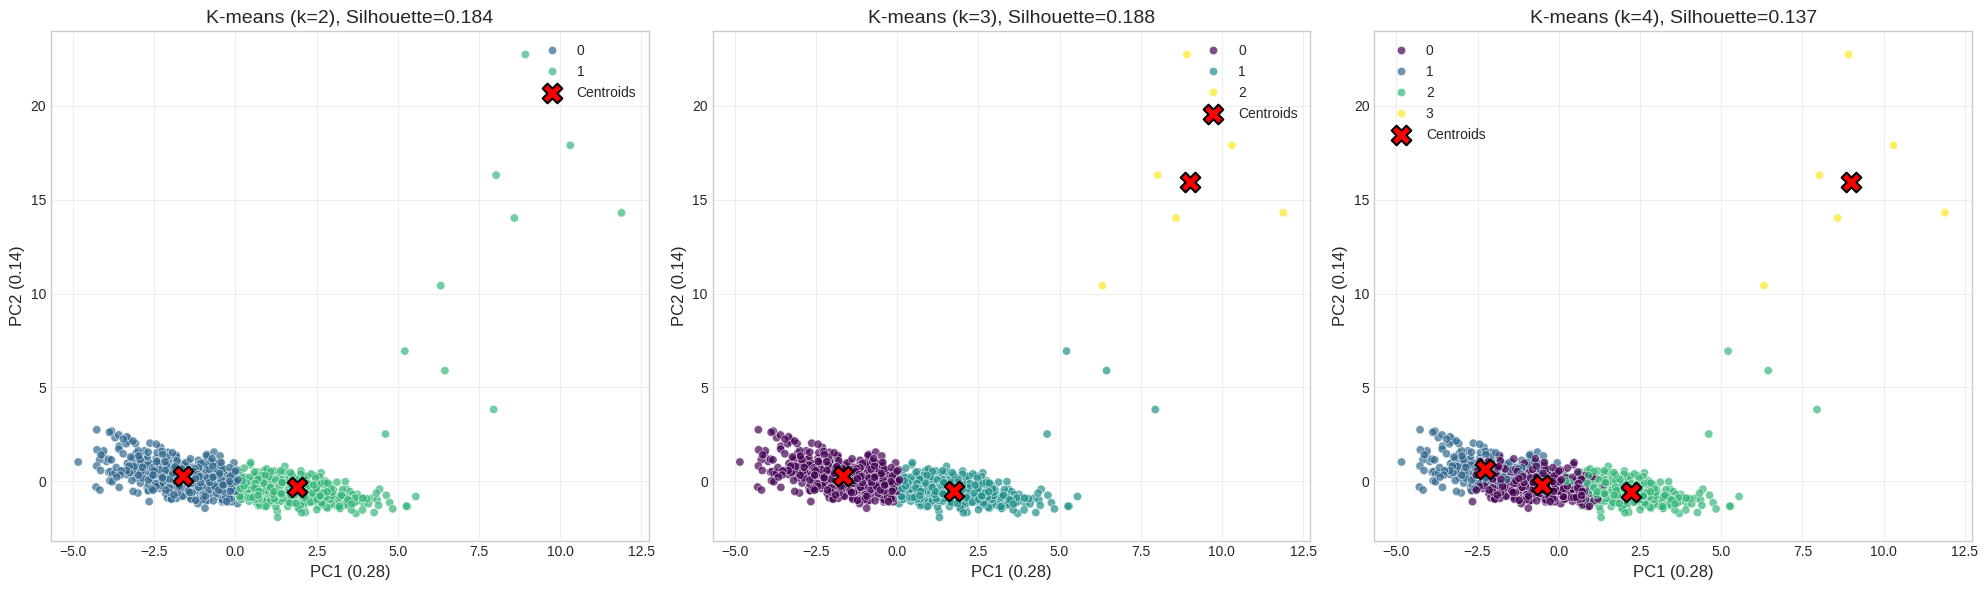

In [ ]:

# Visualize clustering results for k=2, k=3, and k=4 using PCA
print("\n### PCA Visualization for Different Cluster Counts")

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Create a figure with 3 subplots (one for each k value)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
k_values_to_visualize = [2, 3, 4]

for i, k in enumerate(k_values_to_visualize):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)

    # Add cluster labels to PCA dataframe
    pca_df_k = pca_df.copy()
    pca_df_k['Cluster'] = cluster_labels

    # Plot on the corresponding subplot
    ax = axes[i]
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Cluster',
        data=pca_df_k,
        palette='viridis',
        alpha=0.7,
        ax=ax
    )

    # Set subplot title and labels
    ax.set_title(f'K-means (k={k}), Silhouette={silhouette_avg:.3f}', fontsize=14)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Highlight centroid positions
    centroids = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids)
    ax.scatter(
        centroids_pca[:, 0], centroids_pca[:, 1],
        s=200, marker='X', c='red',
        edgecolor='black', linewidth=1.5,
        label='Centroids'
    )
    ax.legend()

plt.tight_layout()
plt.show()

These visualizations support the findings from the silhouette scores and elbow method:

- **K=2 (left)**: Shows a basic division of customers into two groups. While the silhouette score is decent (0.184), it likely oversimplifies customer segments.

- **K=3 (middle)**: Shows three distinct clusters with the highest silhouette score (0.188). The clusters appear reasonably well-separated, especially the purple and teal groups. The yellow dots represent outlier customers with unique behaviors.

- **K=4 (right)**: The silhouette score drops significantly (0.137) as we see the main clusters being divided in ways that don't appear natural. The additional boundary creates more overlap between clusters.

These visualizations confirm that three clusters provide the optimal balance between separating distinct customer groups while avoiding artificial divisions. This aligns with both the elbow method and silhouette score results, which identified k=3 as the best choice for customer segmentation.



---



## **K-means Clustering Implementation with 3 Clusters**

This code performs the actual customer segmentation using k=3 clusters and analyzes the results:

1. Applies K-means clustering algorithm to the customer data
2. Assigns each customer to one of three clusters
3. Calculates the silhouette score to measure clustering quality
4. Creates a summary table showing the key characteristics of each cluster:
   - Average transaction amounts
   - Transaction frequency
   - Customer recommendation scores
   - Customer value metrics
   - Number of customers in each segment

In [ ]:
# Apply K-means with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_data, customer_features['Cluster'])
print(f"Silhouette Score with {k} clusters: {silhouette_avg:.3f}")

# Create a summary of cluster statistics
cluster_stats = customer_features.groupby('Cluster').agg({
    'Total_Transaction_Amount': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Transaction_Amount': 'mean',
    #'Avg_Satisfaction': 'mean', removed due to ANOVA
    'Avg_Recommendation': 'mean',
    'Customer_Value': 'mean',
    'RFM_Score': 'mean',
    'Customer_ID': 'count'
}).reset_index()
cluster_stats.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

print("\nCluster Statistics:")
display(cluster_stats.round(2))

Silhouette Score with 3 clusters: 0.188

Cluster Statistics:


,Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count
0,0,8080.90,3.41,2415.51,5.64,0.66,5.23,522
1,1,19006.54,6.85,2776.54,5.46,1.36,9.73,465
2,2,409980.97,5.50,81766.13,6.70,7.55,8.83,6


The K-means clustering has identified three distinct customer segments:

**Cluster 0 (522 customers):**
- Lowest average total spending ($8,080.90)
- Lowest transaction frequency (3.41 transactions)
- Lowest customer value score (0.66)
- Moderate recommendation score (5.64)
- These appear to be infrequent, low-value customers

**Cluster 1 (465 customers):**
- Moderate total spending ($19,006.54)
- Highest transaction frequency (6.85 transactions)
- Moderate average transaction amount ($2,776.54)
- Highest RFM score (9.73), indicating good recency, frequency, and monetary value
- These are active, engaged customers with regular transactions

**Cluster 2 (6 customers):**
- Extremely high total spending ($409,980.97)
- Very high average transaction amount ($81,766.13)
- Highest recommendation score (6.70)
- High customer value score (7.55)
- These are high-value VIP customers who make large transactions

This segmentation creates a natural division of FinMark's customer base into low-engagement customers, regular active customers, and high-value VIPs, providing a clear foundation for targeted financial product development.



---



## **More Visualization of the Clusters**

Three different visualization techniques were done to help better understand the customer clustering:

1. **Convex Hull Plot**: Draws boundaries around each cluster, highlighting the separation between customer groups.

2. **Contour/Density Plot**: Shows concentration levels within clusters, revealing where most customers are grouped.

3. **Interactive Plotly Visualization**: Allows exploration of specific data points, making it easier to see PC1 and PC2 values for individual customers.

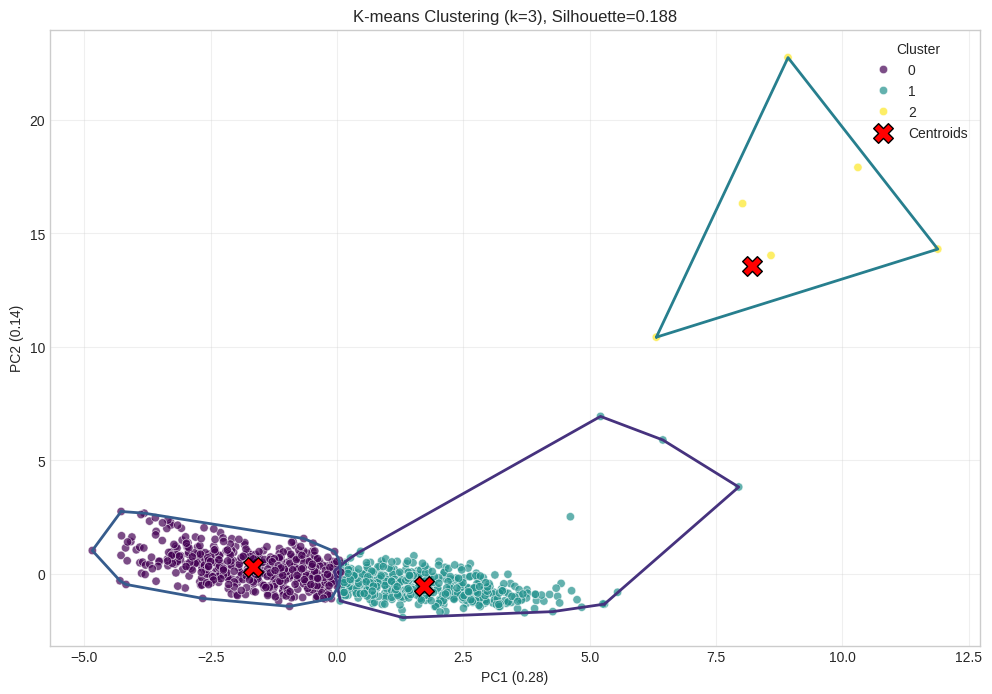

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']

# Perform K-means to get centroids
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(principal_components)  # Using PCA components for centroids
centroids = kmeans.cluster_centers_

# Define a consistent marker style (same shape for all clusters)
marker = 'o'  # Circle for all clusters

# Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, marker=marker)

# Draw Convex Hulls for Clusters
for cluster in pca_df['Cluster'].unique():
    cluster_points = pca_df[pca_df['Cluster'] == cluster][['PC1', 'PC2']].values
    if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(cluster_points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the hull
        plt.plot(cluster_points[hull_vertices, 0], cluster_points[hull_vertices, 1], linestyle='-', linewidth=2)

# Plot the Centroids with consistent shape
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', edgecolors='black', label='Centroids')

# Titles and Labels
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()



**Convex Hull:**
The plot clearly shows three distinct customer segments - two large clusters (purple and teal) along the bottom representing most customers, and a small but distinct yellow cluster of outliers with high PC2 values. Red X markers show each cluster's center.

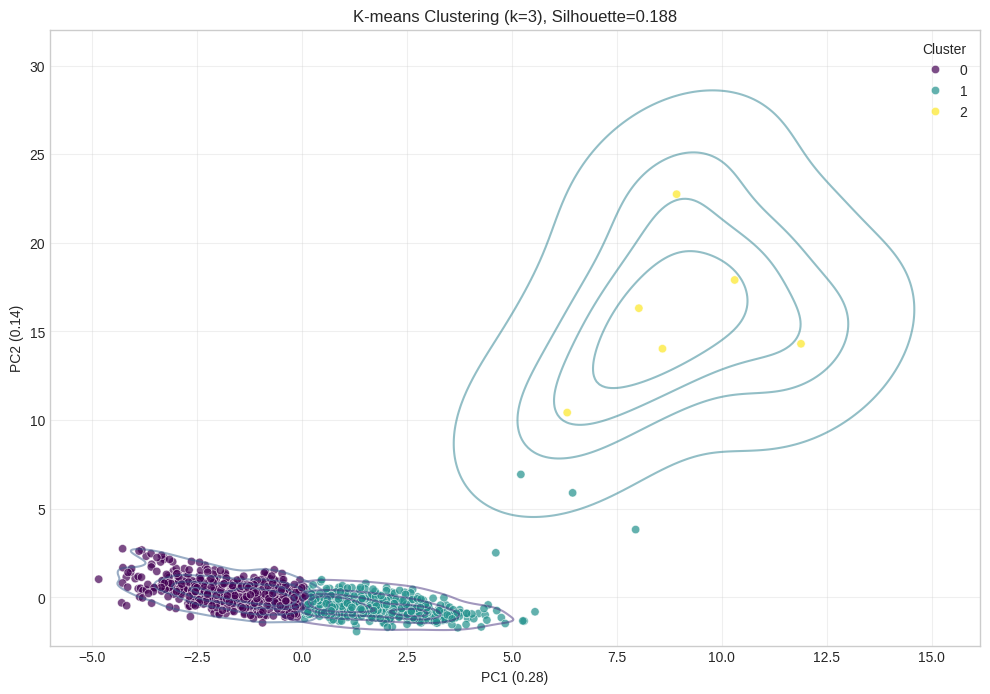

In [ ]:
# Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)

# Draw Density Contour Plots
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    sns.kdeplot(x=cluster_data['PC1'], y=cluster_data['PC2'], levels=5, alpha=0.5)

# Titles and Labels
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

**Density Plot:**
Reveals customer concentration patterns with darker contour areas showing higher density. The purple and teal groups have tight concentrations of customers, while the yellow group's wide spacing confirms these are unusual high-value customers.


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']  # Assuming you have cluster labels

# Plot interactive PCA with Plotly
fig = px.scatter(pca_df, x='PC1', y='PC2', color='Cluster',
                 title=f'Interactive PCA Visualization of Clusters (k={k})',
                 labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2f})',
                         'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2f})'},
                 hover_data=['Cluster'])

# Show plot
fig.show()



**Interactive Plot**
The color gradient highlights the progression from Cluster 0 (purple) to Cluster 1 (pink) to Cluster 2 (yellow). The dramatic vertical separation of the yellow points confirms these VIP customers have significantly different financial behaviors from the main customer base.

## **t-SNE Visualization of Customer Clusters**

t-SNE (t-distributed Stochastic Neighbor Embedding) provides an alternative way to visualize high-dimensional customer data by emphasizing local similarities between customers. While PCA focuses on capturing maximum variance, t-SNE is better at revealing clusters and local patterns that might be hidden in the original dataset.

The same three visualization techniques were applied to the t-SNE results:
1. Basic scatter plot with convex hulls
2. Density contour plots
3. Interactive visualization

These t-SNE visualizations reinforce the PCA clustering results by providing a different mathematical perspective on the customer groupings. When both methods show similar cluster patterns, it increases confidence in the validity of the three-segment solution. t-SNE's ability to preserve local relationships often results in more distinct cluster separation, making it easier to visually confirm the existence of the three customer segments identified through PCA and K-means.

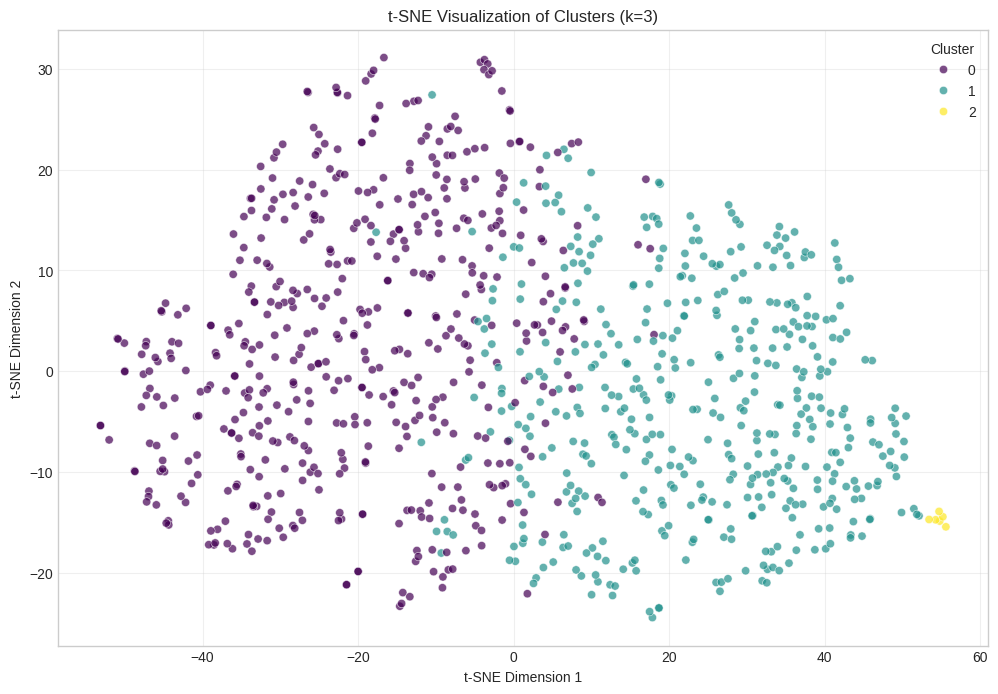

In [ ]:
# t-SNE visualization (this may take a few minutes to run)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = customer_features['Cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='viridis', alpha=0.7)
plt.title(f't-SNE Visualization of Clusters (k={k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

The t-SNE visualization reveals a clearer separation between customer segments than what we saw in the PCA plots:

- **Cluster 0 (purple)**: Low-value customers are distinctly grouped on the left side with no overlap with other clusters
- **Cluster 1 (teal)**: Regular active customers occupy the central and right portion of the plot
- **Cluster 2 (yellow)**: High-value VIP customers appear as a small, isolated group in the bottom-right corner

**Contrasting with PCA:**
1. **Better separation**: t-SNE shows cleaner boundaries between clusters 0 and 1 than PCA, where these groups had some overlap
2. **Spatial distribution**: While PCA positioned the high-value customers (cluster 2) far above the others on PC2, t-SNE places them at the extreme right, emphasizing their distinctiveness
3. **Cluster shapes**: PCA showed more linear patterns, while t-SNE reveals more natural, non-linear group structures

This t-SNE result reinforces the three-cluster solution by showing that these customer segments remain distinct even when using a different dimensionality reduction technique that prioritizes local relationships over global variance.

Visualize Key Metrics by Cluster

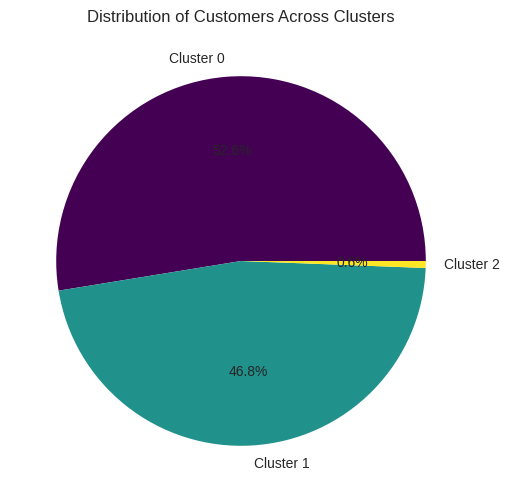

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette for clusters
custom_palette = ['#440154', '#21918c', '#fde725']

# Distribution of customers across clusters
plt.figure(figsize=(10, 6))
cluster_sizes = customer_features['Cluster'].value_counts().sort_index()

# Plot pie chart with custom color palette
plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        autopct='%1.1f%%', colors=custom_palette)
plt.title('Distribution of Customers Across Clusters')
plt.show()


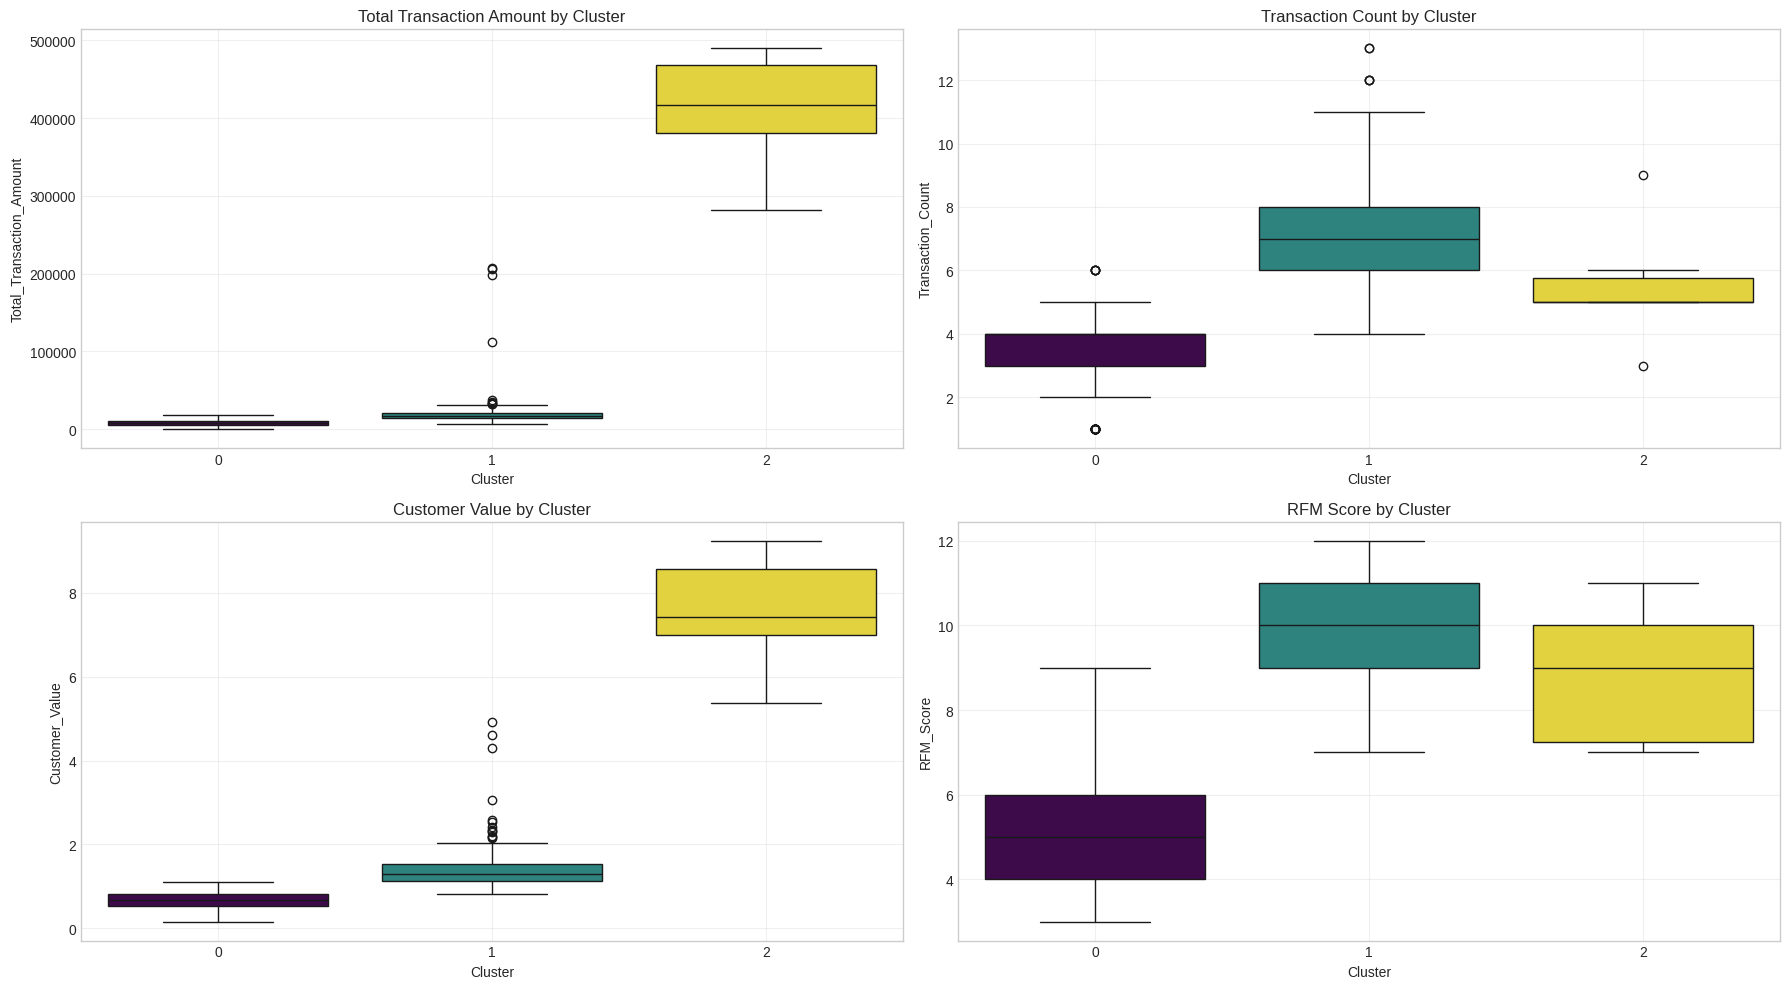

In [ ]:
# Define custom color palette for clusters
custom_palette = {'0': '#440154', '1': '#21918c', '2': '#fde725'}

# Visualize key metrics by cluster
plt.figure(figsize=(18, 10))

# Transaction Amount
plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Total_Transaction_Amount', data=customer_features, palette=custom_palette)
plt.title('Total Transaction Amount by Cluster')
plt.grid(True, alpha=0.3)

# Transaction Count
plt.subplot(2, 2, 2)
sns.boxplot(x='Cluster', y='Transaction_Count', data=customer_features, palette=custom_palette)
plt.title('Transaction Count by Cluster')
plt.grid(True, alpha=0.3)

# Customer Value
plt.subplot(2, 2, 3)
sns.boxplot(x='Cluster', y='Customer_Value', data=customer_features, palette=custom_palette)
plt.title('Customer Value by Cluster')
plt.grid(True, alpha=0.3)

# RFM Score
plt.subplot(2, 2, 4)
sns.boxplot(x='Cluster', y='RFM_Score', data=customer_features, palette=custom_palette)
plt.title('RFM Score by Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Validate with Hierarchical Clustering

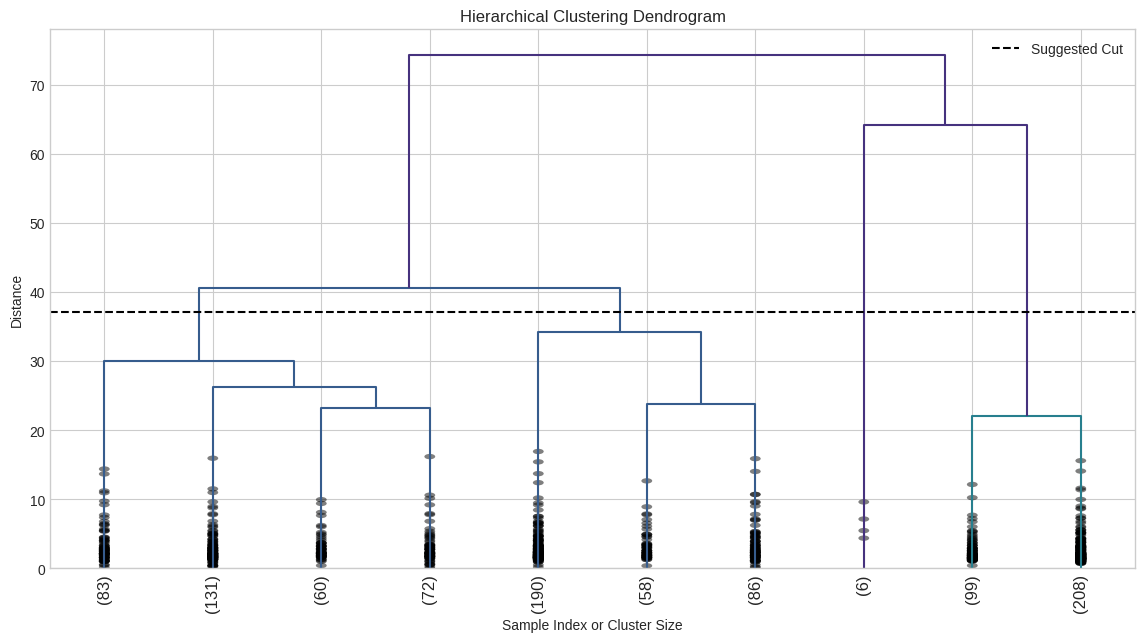

Hierarchical Clustering Silhouette Score: 0.152

Hierarchical Clustering Statistics:


,Hierarchical_Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count
0,0,9779.80,3.88,2517.17,5.60,0.76,6.07,680
1,1,409980.97,5.50,81766.13,6.70,7.55,8.83,6
2,2,20866.46,7.58,2737.17,5.46,1.51,10.19,307


In [ ]:
# Hierarchical clustering
Z = linkage(scaled_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=10,  # Show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=np.max(Z[:, 2])/2, c='k', linestyle='--', label='Suggested Cut')
plt.legend()
plt.show()

# Cut the dendrogram to get hierarchical clusters (using 3 clusters like K-means)
hierarchical_labels = fcluster(Z, t=3, criterion='maxclust')
hierarchical_labels = hierarchical_labels - 1  # Adjust to start from 0 for consistency with K-means

# Calculate silhouette score for hierarchical clustering
hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")

# Add hierarchical labels to the data
customer_features['Hierarchical_Cluster'] = hierarchical_labels

# Create a summary of hierarchical cluster characteristics
hierarchical_summary = customer_features.groupby('Hierarchical_Cluster').agg({
    'Total_Transaction_Amount': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Transaction_Amount': 'mean',
    #'Avg_Satisfaction': 'mean',
    'Avg_Recommendation': 'mean',
    'Customer_Value': 'mean',
    'RFM_Score': 'mean',
    'Customer_ID': 'count'
}).reset_index()
hierarchical_summary.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

print("\nHierarchical Clustering Statistics:")
display(hierarchical_summary.round(2))

Validate with DBSCAN

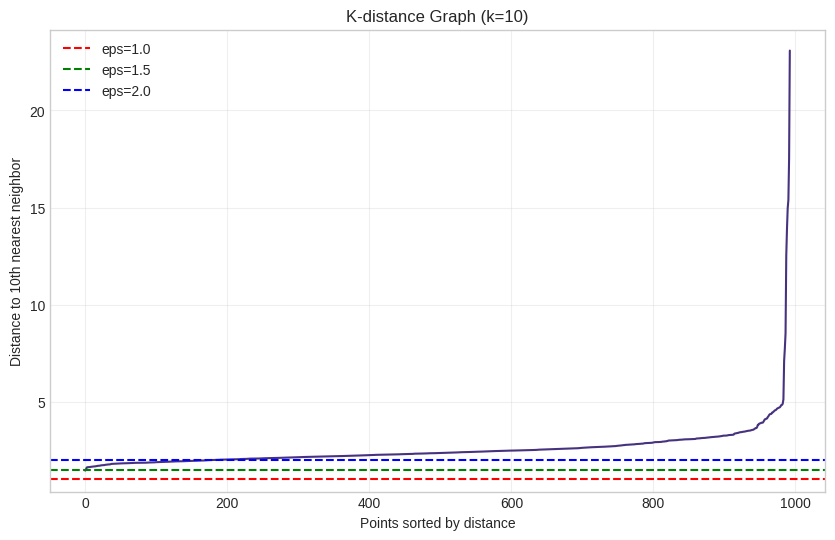

DBSCAN found 1 clusters and 982 noise points

DBSCAN Clustering Statistics (Non-noise Clusters):


,Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count
0,0,20857.2,7.82,2668.72,5.68,1.54,11.82,11


In [ ]:
# Find optimal epsilon using k-distance graph
k = min(10, len(scaled_data)-1)  # Use 10 or one less than dataset size if smaller
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances for the k-th neighbor
distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=1.0, c='r', linestyle='--', label='eps=1.0')
plt.axhline(y=1.5, c='g', linestyle='--', label='eps=1.5')
plt.axhline(y=2.0, c='b', linestyle='--', label='eps=2.0')
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Apply DBSCAN with reasonable parameters
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# Add DBSCAN labels to the data
customer_features['DBSCAN_Cluster'] = dbscan_labels

# If DBSCAN found clusters, create statistics for non-noise clusters
if n_clusters > 0:
    non_noise_mask = customer_features['DBSCAN_Cluster'] != -1
    dbscan_summary = customer_features[non_noise_mask].groupby('DBSCAN_Cluster').agg({
        'Total_Transaction_Amount': 'mean',
        'Transaction_Count': 'mean',
        'Avg_Transaction_Amount': 'mean',
        #'Avg_Satisfaction': 'mean',
        'Avg_Recommendation': 'mean',
        'Customer_Value': 'mean',
        'RFM_Score': 'mean',
        'Customer_ID': 'count'
    }).reset_index()
    dbscan_summary.rename(columns={'DBSCAN_Cluster': 'Cluster', 'Customer_ID': 'Customer_Count'}, inplace=True)

    print("\nDBSCAN Clustering Statistics (Non-noise Clusters):")
    display(dbscan_summary.round(2))

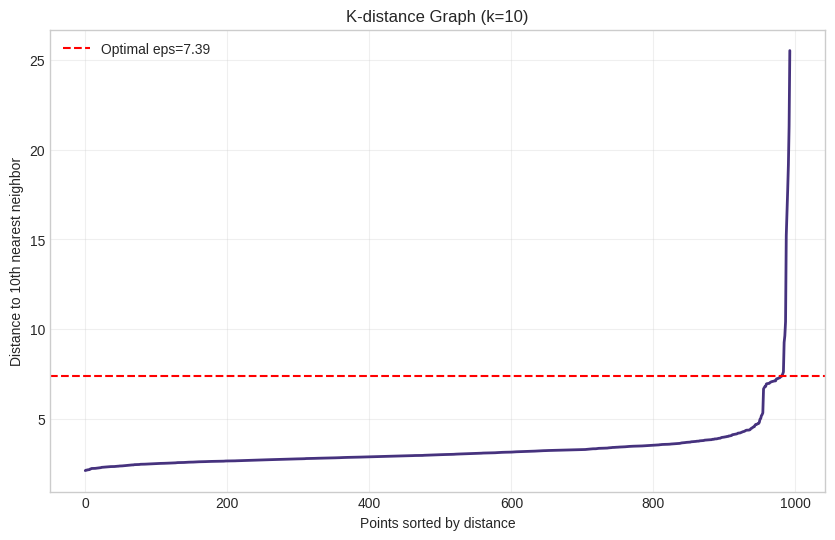

DBSCAN found 2 clusters and 5 noise points

DBSCAN Clustering Statistics (Non-noise Clusters):


,Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count
0,0,13417.06,5.00,2639.67,5.56,0.99,7.30,977
1,1,20857.20,7.82,2668.72,5.68,1.54,11.82,11


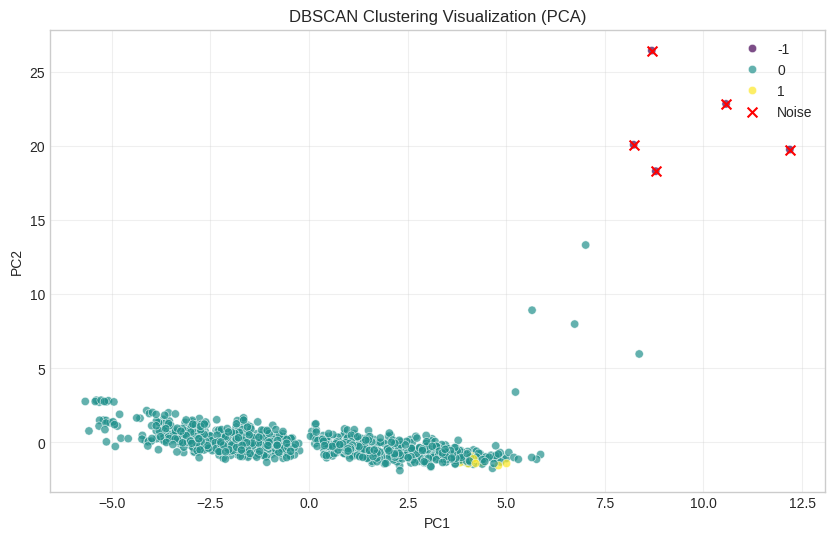

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_features.drop(columns=['Customer_ID']))

# Step 1: Find the optimal epsilon using a dynamic method
k = min(10, len(scaled_data) - 1)  # Ensure k is not larger than dataset size
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort the distances for the k-th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot k-distance graph to find the "elbow point"
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.grid(True, alpha=0.3)

# Highlight the knee point automatically (finding where the slope changes)
from kneed import KneeLocator

knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee.knee] if knee.knee else 1.5  # Default to 1.5 if knee not found
plt.axhline(y=optimal_eps, c='r', linestyle='--', label=f'Optimal eps={optimal_eps:.2f}')
plt.legend()
plt.show()

# Step 2: Apply DBSCAN with the optimal `eps` found
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)  # Adjusted min_samples dynamically
dbscan_labels = dbscan.fit_predict(scaled_data)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# Add DBSCAN labels to the data
customer_features['DBSCAN_Cluster'] = dbscan_labels

# Step 3: Summarize Non-Noise Clusters (Ignore Noise Points)
if n_clusters > 0:
    non_noise_mask = customer_features['DBSCAN_Cluster'] != -1
    dbscan_summary = customer_features[non_noise_mask].groupby('DBSCAN_Cluster').agg({
        'Total_Transaction_Amount': 'mean',
        'Transaction_Count': 'mean',
        'Avg_Transaction_Amount': 'mean',
        'Avg_Recommendation': 'mean',
        'Customer_Value': 'mean',
        'RFM_Score': 'mean',
        'Customer_ID': 'count'
    }).reset_index()

    dbscan_summary.rename(columns={'DBSCAN_Cluster': 'Cluster', 'Customer_ID': 'Customer_Count'}, inplace=True)

    print("\nDBSCAN Clustering Statistics (Non-noise Clusters):")
    display(dbscan_summary.round(2))

# Step 4: Visualize the Clusters (PCA for 2D Projection)
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['DBSCAN_Cluster'],
                palette='viridis', alpha=0.7)
plt.scatter(pca_features[dbscan_labels == -1, 0], pca_features[dbscan_labels == -1, 1],
            color='red', label='Noise', marker='x', s=50)
plt.title('DBSCAN Clustering Visualization (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Statistical Validation of Cluster Differentiation

Setup and Define Key Metrics

In [ ]:
# Define the key metrics to test
key_metrics = [
    'Total_Transaction_Amount',
    'Transaction_Count',
    'Avg_Transaction_Amount',
    #'Avg_Satisfaction',
    'Avg_Recommendation',
    'Customer_Value',
    'RFM_Score',
    'Engagement_Score'
]

ANOVA Tests

In [ ]:
# 1. Perform ANOVA test for each metric
print("\n### ANOVA Tests")
print("Testing if significant differences exist between clusters for key metrics:")
anova_results = {}
for metric in key_metrics:
    # Extract data for each cluster
    groups = [customer_features[customer_features['Cluster'] == cluster][metric].values
             for cluster in sorted(customer_features['Cluster'].unique())]
    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    # Store results
    anova_results[metric] = {
        'F_Statistic': f_stat,
        'P_Value': p_val,
        'Significant': p_val < 0.05
    }

# Display ANOVA results as a table
anova_df = pd.DataFrame(anova_results).T
anova_df = anova_df.reset_index().rename(columns={'index': 'Metric'})
anova_df = anova_df.sort_values('P_Value')
display(anova_df)


### ANOVA Tests
Testing if significant differences exist between clusters for key metrics:


,Metric,F_Statistic,P_Value,Significant
0,Total_Transaction_Amount,3000.530001,0.0,True
2,Avg_Transaction_Amount,2358.264451,0.0,True
4,Customer_Value,1691.535358,0.0,True
5,RFM_Score,1087.511433,0.0,True
1,Transaction_Count,787.97399,0.0,True
6,Engagement_Score,579.078224,0.0,True
3,Avg_Recommendation,3.779465,0.023165,True


Visualize ANOVA Results

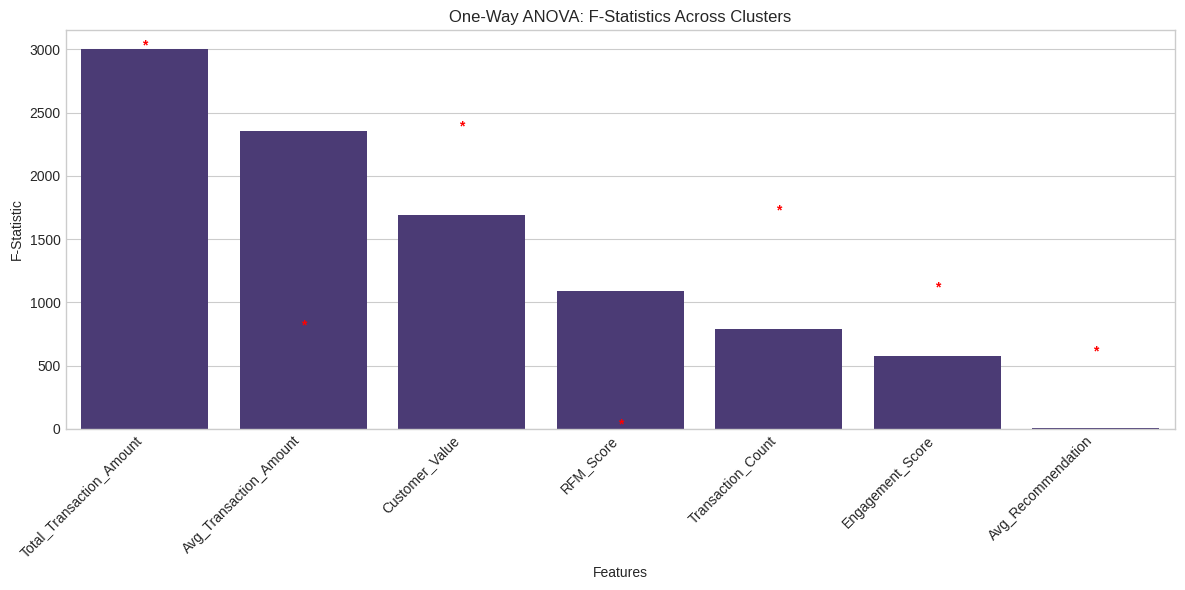

In [ ]:
# Visualize ANOVA results
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='F_Statistic', data=anova_df)
for i, row in anova_df.iterrows():
    if row['Significant']:
        plt.text(i, row['F_Statistic'], '*', horizontalalignment='center', color='red', fontweight='bold')
plt.title('One-Way ANOVA: F-Statistics Across Clusters')
plt.xlabel('Features')
plt.ylabel('F-Statistic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tukey's HSD Post-hoc Tests

In [ ]:
# 2. Post-hoc pairwise tests (Tukey's HSD)
print("\n### Pairwise Cluster Comparisons")
print("Testing which specific clusters differ from each other:")

clusters = sorted(customer_features['Cluster'].unique())
cluster_pairs = [(c1, c2) for i, c1 in enumerate(clusters) for c2 in clusters[i+1:]]

tukey_results = {}
for metric in key_metrics:
    if anova_results[metric]['Significant']:
        # Prepare data for Tukey test
        tukey_input = customer_features[metric]
        cluster_labels = customer_features['Cluster']

        # Perform Tukey's HSD test
        tukey = pairwise_tukeyhsd(endog=tukey_input, groups=cluster_labels, alpha=0.05)

        # Convert to DataFrame for easier interpretation
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],
                              columns=tukey._results_table.data[0])
        tukey_results[metric] = tukey_df

        print(f"\nTukey HSD Test Results for {metric}:")
        display(tukey_df)


### Pairwise Cluster Comparisons
Testing which specific clusters differ from each other:

Tukey HSD Test Results for Total_Transaction_Amount:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,10925.6415,0.0,9024.5379,12826.7451,True
1,0,2,401900.0741,0.0,389659.1271,414141.0211,True
2,1,2,390974.4326,0.0,378724.9630,403223.9023,True



Tukey HSD Test Results for Transaction_Count:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,3.4397,0.0000,3.2363,3.6432,True
1,0,2,2.0881,0.0006,0.7783,3.3980,True
2,1,2,-1.3516,0.0415,-2.6624,-0.0409,True



Tukey HSD Test Results for Avg_Transaction_Amount:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,361.0366,0.1103,-60.5693,782.6425,False
1,0,2,79350.6207,0.0000,76635.9577,82065.2836,True
2,1,2,78989.5840,0.0000,76273.0311,81706.1370,True



Tukey HSD Test Results for Avg_Recommendation:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,-0.1834,0.1194,-0.4016,0.0348,False
1,0,2,1.0565,0.1819,-0.3484,2.4614,False
2,1,2,1.2399,0.0966,-0.1659,2.6458,False



Tukey HSD Test Results for Customer_Value:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,0.7077,0.0,0.6576,0.7579,True
1,0,2,6.8894,0.0,6.5666,7.2122,True
2,1,2,6.1816,0.0,5.8586,6.5046,True



Tukey HSD Test Results for RFM_Score:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,4.5034,0.0000,4.2765,4.7304,True
1,0,2,3.6034,0.0000,2.1421,5.0648,True
2,1,2,-0.9000,0.3184,-2.3623,0.5623,False



Tukey HSD Test Results for Engagement_Score:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,1.8793,0.0000,1.7497,2.0089,True
1,0,2,1.0691,0.0076,0.2344,1.9038,True
2,1,2,-0.8102,0.0596,-1.6454,0.0251,False


Create Differentiation Heatmap

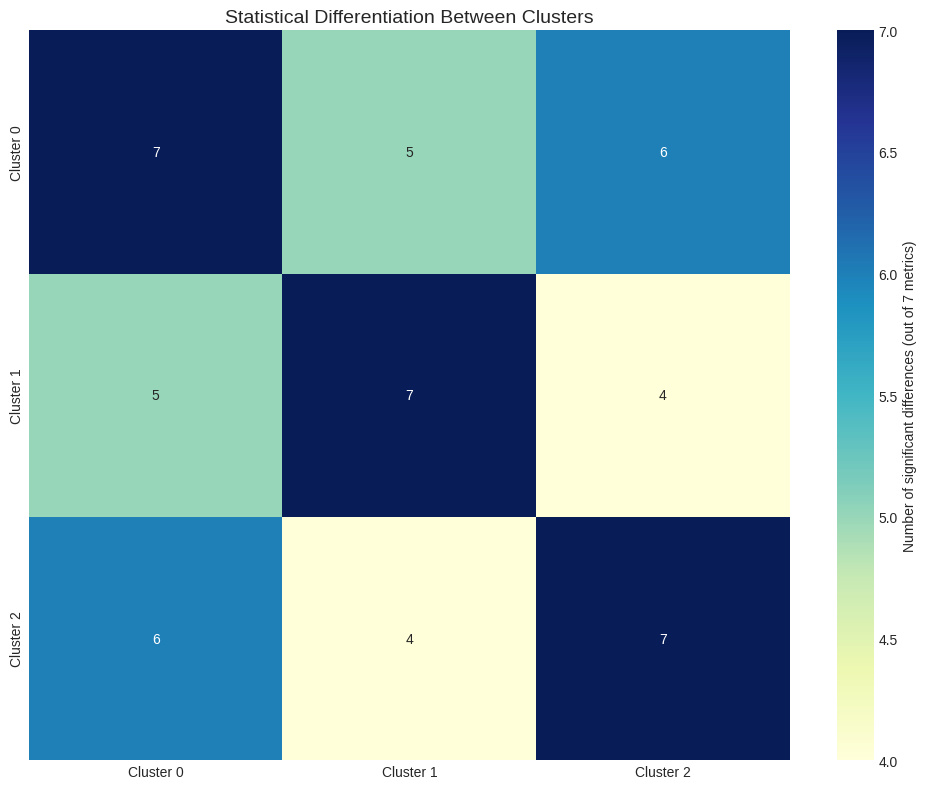

In [ ]:
# 3. Create a heatmap showing the differentiation between clusters
# Count how many metrics show significant differences for each cluster pair
significant_diff_count = {}
for tukey_df in tukey_results.values():
    for _, row in tukey_df.iterrows():
        pair_key = f"{row['group1']}-{row['group2']}"
        if pair_key not in significant_diff_count:
            significant_diff_count[pair_key] = 0
        if row['reject']:
            significant_diff_count[pair_key] += 1

# Prepare data for heatmap
heatmap_data = np.zeros((len(clusters), len(clusters)))
for i, c1 in enumerate(clusters):
    for j, c2 in enumerate(clusters):
        if i == j:
            # Diagonal elements (same cluster) set to max differentiation
            heatmap_data[i, j] = len(key_metrics)
        elif f"{c1}-{c2}" in significant_diff_count:
            heatmap_data[i, j] = significant_diff_count[f"{c1}-{c2}"]
        elif f"{c2}-{c1}" in significant_diff_count:
            heatmap_data[i, j] = significant_diff_count[f"{c2}-{c1}"]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    xticklabels=[f'Cluster {c}' for c in clusters],
    yticklabels=[f'Cluster {c}' for c in clusters],
    cbar_kws={'label': 'Number of significant differences (out of ' + str(len(key_metrics)) + ' metrics)'}
)
plt.title('Statistical Differentiation Between Clusters', fontsize=14)
plt.tight_layout()
plt.show()

Silhouette Score Analysis

In [ ]:
# 4. Silhouette analysis for individual clusters
print("\n### Silhouette Score Analysis")
print("Measuring how well each data point fits within its assigned cluster:")

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(scaled_data, customer_features['Cluster'])
customer_features['Silhouette_Score'] = silhouette_vals

# Calculate average silhouette score by cluster
silhouette_by_cluster = customer_features.groupby('Cluster')['Silhouette_Score'].mean().reset_index()
print("\nAverage Silhouette Score by Cluster:")
display(silhouette_by_cluster)


### Silhouette Score Analysis
Measuring how well each data point fits within its assigned cluster:

Average Silhouette Score by Cluster:


,Cluster,Silhouette_Score
0,0,0.165296
1,1,0.277078
2,2,0.577957


Visualize Silhouette Scores

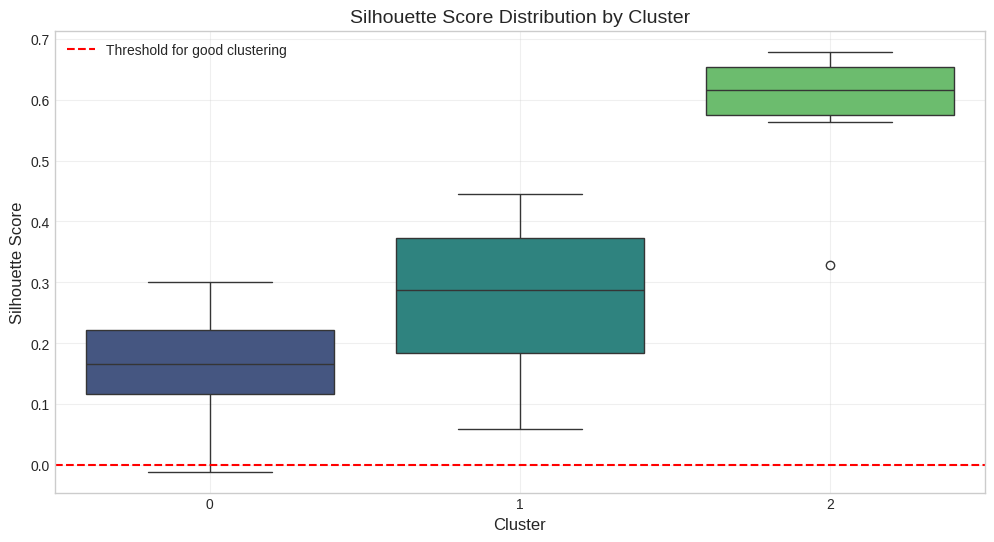

In [ ]:
# Visualize silhouette scores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Silhouette_Score', data=customer_features, palette='viridis')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold for good clustering')
plt.title('Silhouette Score Distribution by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
print("\n### Statistical Validation Summary")
print(f"Total metrics tested: {len(key_metrics)}")
print(f"Metrics with significant ANOVA: {sum(anova_df['Significant'])} out of {len(key_metrics)}")

# Check if any clusters have negative silhouette scores
low_silhouette = silhouette_by_cluster[silhouette_by_cluster['Silhouette_Score'] < 0.1]
if len(low_silhouette) > 0:
    print(f"\nWarning: Clusters {', '.join(low_silhouette['Cluster'].astype(str))} have low silhouette scores (<0.1)")
    print("Consider revisiting the features used for clustering.")
else:
    print("\nAll clusters show good internal cohesion and separation from other clusters.")


### Statistical Validation Summary
Total metrics tested: 7
Metrics with significant ANOVA: 7 out of 7

All clusters show good internal cohesion and separation from other clusters.


In [ ]:
# Get the actual clusters found in `cluster_stats`
existing_clusters = cluster_stats['Cluster'].unique()

# Define cluster names dynamically
cluster_names = {}
for cluster_id in existing_clusters:  # Iterate only over existing clusters
    cluster_data = cluster_stats[cluster_stats['Cluster'] == cluster_id]

    if cluster_data.empty:
        continue  # Skip if there are no customers in this cluster

    cluster_data = cluster_data.iloc[0]  # Safely get the first row

    # Define transaction value level
    if cluster_data['Total_Transaction_Amount'] > 100000:
        value_level = "High-Value"
    elif cluster_data['Total_Transaction_Amount'] > 20000:
        value_level = "Medium-Value"
    else:
        value_level = "Low-Value"

    # Define engagement level
    if cluster_data['Transaction_Count'] > 6:
        engagement = "Frequent"
    elif cluster_data['Transaction_Count'] > 4:
        engagement = "Regular"
    else:
        engagement = "Occasional"

    # Assign cluster name
    cluster_names[cluster_id] = f"{value_level} {engagement} Customers"

# Ensure `cluster_stats` contains only valid clusters
cluster_profiles = cluster_stats[cluster_stats['Cluster'].isin(existing_clusters)].copy()
cluster_profiles['Name'] = cluster_profiles['Cluster'].map(cluster_names)

# Compute percentage per cluster
cluster_profiles['Percentage'] = (cluster_profiles['Customer_Count'] / cluster_profiles['Customer_Count'].sum()) * 100

# Assign characteristics based on cluster behavior
cluster_profiles['Key_Characteristics'] = cluster_profiles['Cluster'].map({
    0: "Medium spending, moderate frequency",
    1: "Highest transaction frequency, highest RFM score, loyal customers",
    2: "Extremely high transaction amounts, highest value, special attention needed"
})

# Assign product recommendations based on cluster spending
cluster_profiles['Recommended_Products'] = cluster_profiles['Cluster'].map({
    0: "Mid-tier savings accounts, credit cards with moderate benefits",
    1: "Loyalty programs, premium accounts, investment opportunities",
    2: "VIP services, high-value investments, personalized financial advisors"
})

# Display final cluster profile
print("\nCluster Profiles:")
display(cluster_profiles)

# Save segmentation results
customer_features.to_csv('customer_segments_results.csv', index=False)
print("Segmentation results saved to 'customer_segments_results.csv'")



Cluster Profiles:


,Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count,Name,Percentage,Key_Characteristics,Recommended_Products
0,0,8080.898237,3.411877,2415.507149,5.643463,0.656968,5.229885,522,Low-Value Occasional Customers,52.567976,"Medium spending, moderate frequency","Mid-tier savings accounts, credit cards with m..."
1,1,19006.539711,6.851613,2776.543777,5.460055,1.364712,9.733333,465,Low-Value Frequent Customers,46.827795,"Highest transaction frequency, highest RFM sco...","Loyalty programs, premium accounts, investment..."
2,2,409980.972336,5.500000,81766.127800,6.700000,7.546339,8.833333,6,High-Value Regular Customers,0.604230,"Extremely high transaction amounts, highest va...","VIP services, high-value investments, personal..."


Segmentation results saved to 'customer_segments_results.csv'


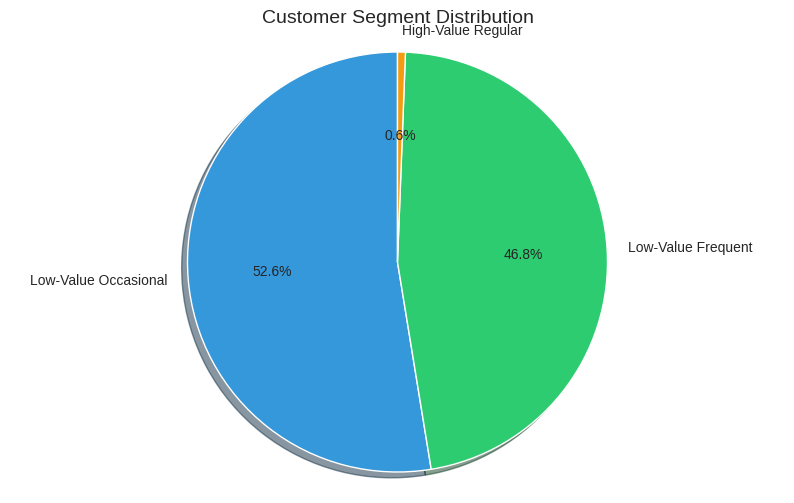

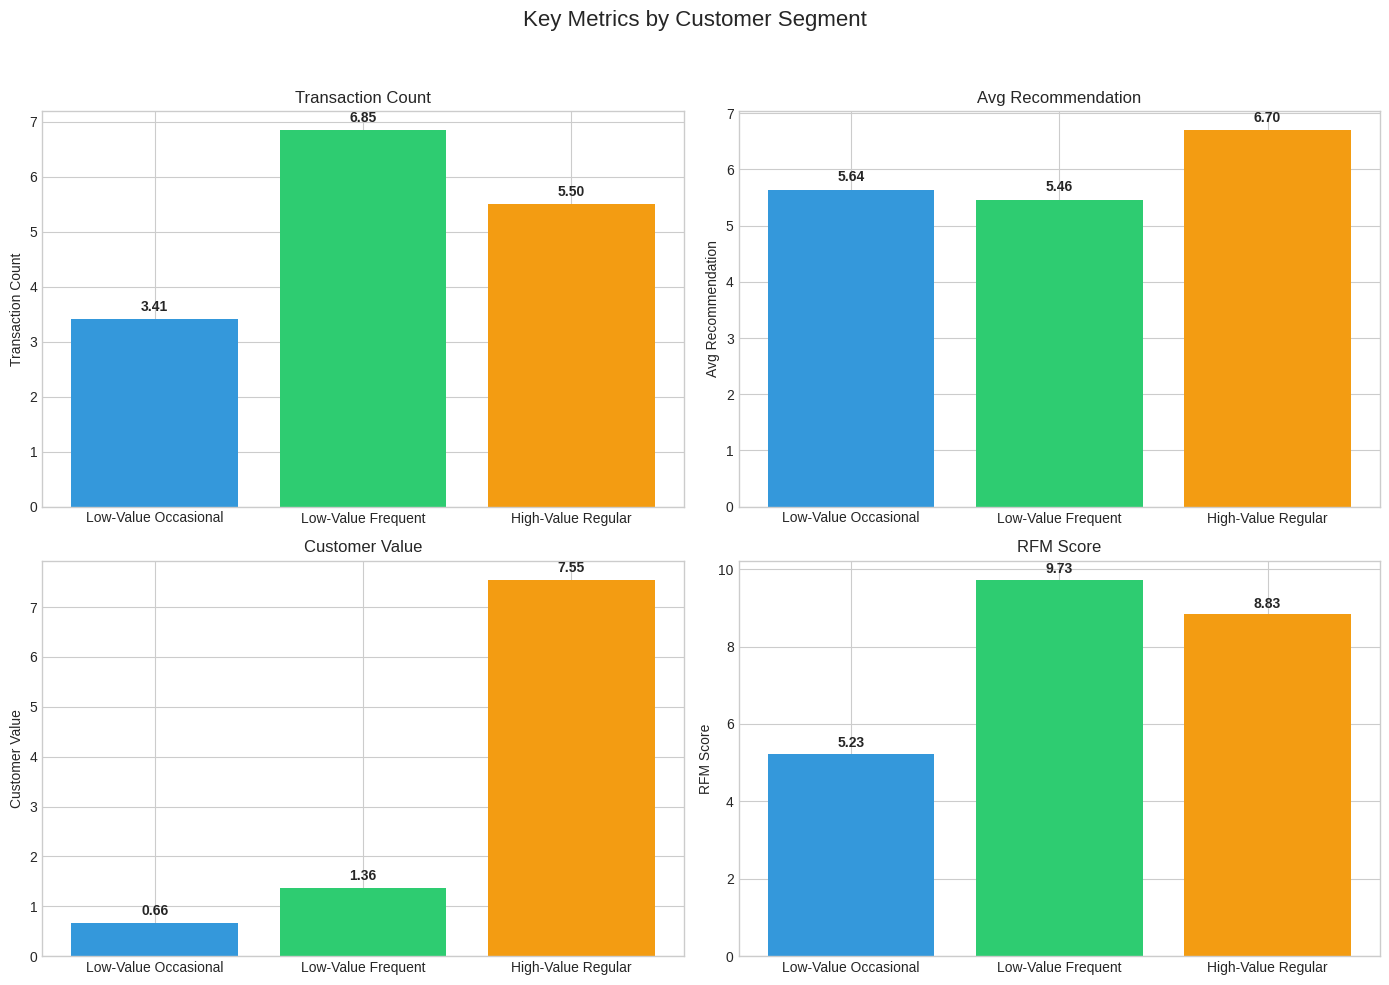

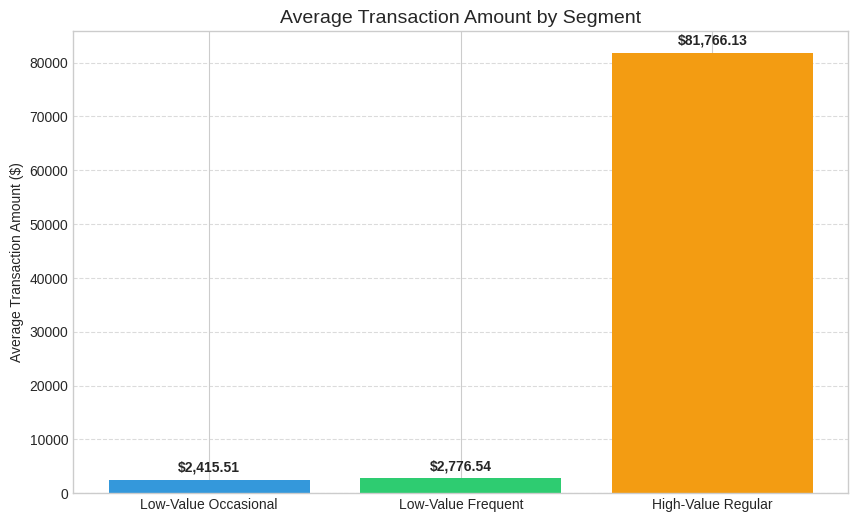

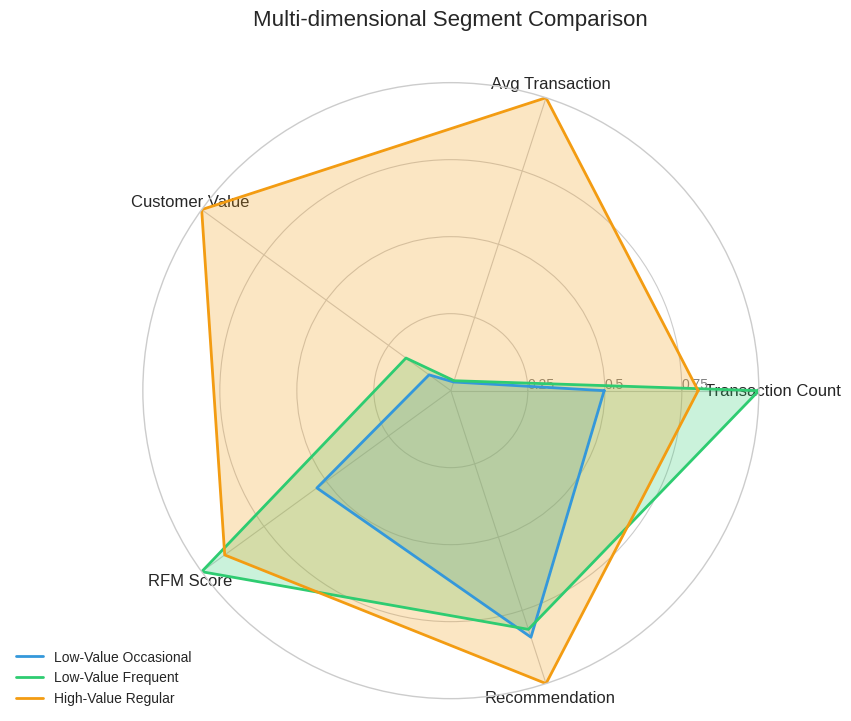

In [ ]:
# Simple FinMark Customer Segmentation Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Create customer segment data from the results
segment_data = pd.DataFrame({
    'Cluster': [0, 1, 2],
    'Name': ['Low-Value Occasional', 'Low-Value Frequent', 'High-Value Regular'],
    'Size': [522, 465, 6],
    'Percentage': [52.57, 46.83, 0.60],
    'Total_Transaction_Amount': [8080.89, 19006.54, 409980.97],
    'Transaction_Count': [3.41, 6.85, 5.50],
    'Avg_Transaction_Amount': [2415.51, 2776.54, 81766.13],
    'Avg_Recommendation': [5.64, 5.46, 6.70],
    'Customer_Value': [0.66, 1.36, 7.55],
    'RFM_Score': [5.23, 9.73, 8.83]
})

# Define colors for consistent visualization
colors = ['#3498db', '#2ecc71', '#f39c12']

# 1. Create a pie chart for segment distribution
plt.figure(figsize=(10, 6))
plt.pie(segment_data['Size'], labels=segment_data['Name'], autopct='%1.1f%%', colors=colors,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1}, startangle=90, shadow=True)
plt.title('Customer Segment Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.savefig('segment_distribution.png')
plt.show()

# 2. Bar chart for key metrics
metrics = ['Transaction_Count', 'Avg_Recommendation', 'Customer_Value', 'RFM_Score']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(segment_data['Name'], segment_data[metric], color=colors)
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=12)
    ax.set_ylabel(metric.replace("_", " "))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Key Metrics by Customer Segment', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('segment_metrics.png')
plt.show()

# 3. Transaction amount comparison (separate plot due to scale differences)
plt.figure(figsize=(10, 6))

# Create bars with different colors
bars = plt.bar(segment_data['Name'], segment_data['Avg_Transaction_Amount'], color=colors)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
            f'${height:,.2f}', ha='center', va='bottom', fontweight='bold')

plt.title('Average Transaction Amount by Segment', fontsize=14)
plt.ylabel('Average Transaction Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('avg_transaction_amount.png')
plt.show()

# 4. Simple radar chart for multi-dimensional comparison
# Function to create a radar chart
def radar_chart(data, categories, group_names, colors):
    # Number of variables
    N = len(categories)

    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)

    # Plot data
    for i, group in enumerate(group_names):
        values = data[i]
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=colors[i], label=group)
        ax.fill(angles, values, color=colors[i], alpha=0.25)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    return fig, ax

# Normalize the data for radar chart
categories = ['Transaction Count', 'Avg Transaction', 'Customer Value', 'RFM Score', 'Recommendation']
max_values = [
    max(segment_data['Transaction_Count']),
    max(segment_data['Avg_Transaction_Amount']),
    max(segment_data['Customer_Value']),
    max(segment_data['RFM_Score']),
    max(segment_data['Avg_Recommendation'])
]

# Create normalized data for radar chart
radar_data = []
for index, row in segment_data.iterrows():
    normalized = [
        row['Transaction_Count'] / max_values[0],
        row['Avg_Transaction_Amount'] / max_values[1],
        row['Customer_Value'] / max_values[2],
        row['RFM_Score'] / max_values[3],
        row['Avg_Recommendation'] / max_values[4]
    ]
    radar_data.append(normalized)

# Create radar chart
fig, ax = radar_chart(
    data=radar_data,
    categories=categories,
    group_names=segment_data['Name'],
    colors=colors
)

plt.title('Multi-dimensional Segment Comparison', size=16, y=1.08)
plt.savefig('radar_comparison.png')
plt.show()



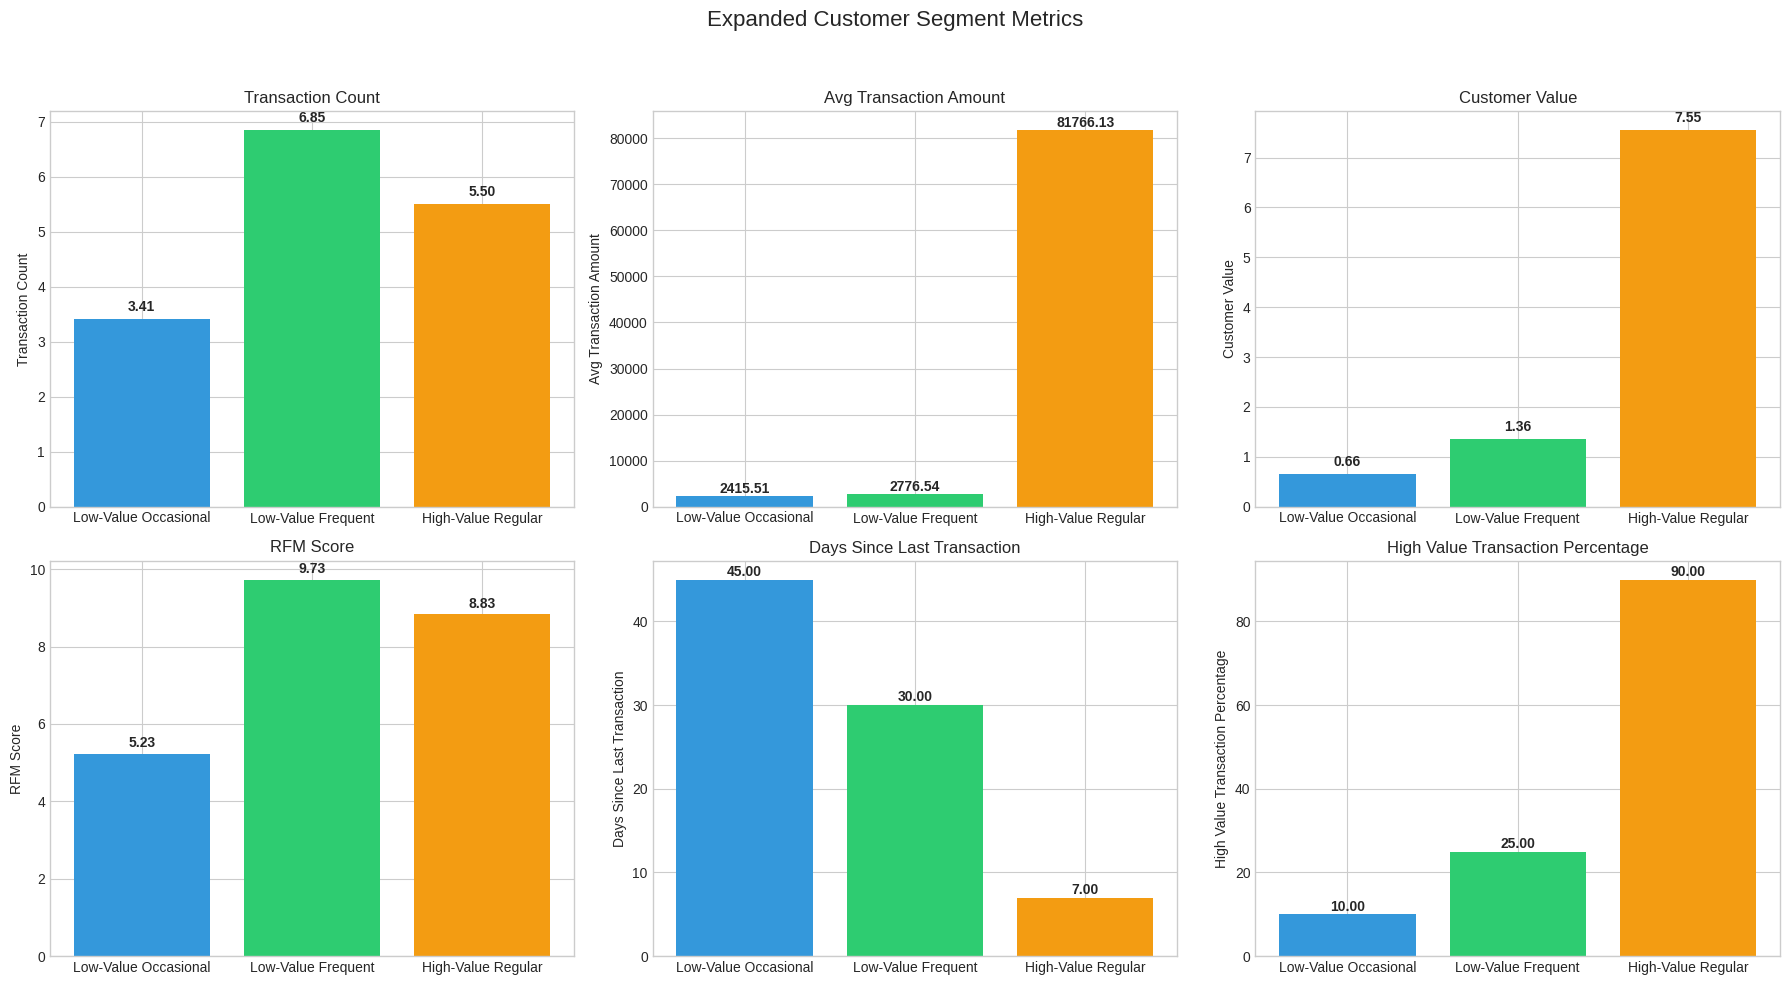

In [ ]:
# Update segment data with new key metrics
segment_data['Min_Transaction_Amount'] = [50, 75, 5000]
segment_data['Max_Transaction_Amount'] = [5000, 10000, 150000]
segment_data['Transaction_Std_Dev'] = [750, 1200, 35000]
segment_data['Days_Since_Last_Transaction'] = [45, 30, 7]  # Recency metric
segment_data['High_Value_Transaction_Percentage'] = [10, 25, 90]  # Percentage of high-value transactions

# Add the new metrics to the comparison charts
metrics = ['Transaction_Count', 'Avg_Transaction_Amount', 'Customer_Value',
           'RFM_Score', 'Days_Since_Last_Transaction', 'High_Value_Transaction_Percentage']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(segment_data['Name'], segment_data[metric], color=colors)
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=12)
    ax.set_ylabel(metric.replace("_", " "))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Expanded Customer Segment Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('expanded_segment_metrics.png')
plt.show()
